In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("NYC_Taxi_Analysis").getOrCreate()

# Load Parquet file
file_path = "/FileStore/tables/yellow_tripdata_2019_01.parquet"  
taxi_df = spark.read.parquet(file_path)

# Sample 1% of the data (~70,000 rows)
sampled_df = taxi_df.sample(fraction=0.01, seed=42)

# Save the sample as a new Parquet file to avoid reloading the big file
sampled_df.write.mode("overwrite").parquet("/FileStore/tables/yellow_tripdata_2019_sample.parquet")

# Load the sampled data for analysis
taxi_df = spark.read.parquet("/FileStore/tables/yellow_tripdata_2019_sample.parquet")

# Show first few rows and schema
taxi_df.show(5)
taxi_df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2019-01-01 00:57:47|  2019-01-01 01:12:37|            1.0|          2.4|       1.0|                 N|         162|         107|           1|       11.5|  0.5|    0.5|      2.5

In [0]:
from pyspark.sql.functions import col

# Remove nulls and filter outliers (e.g., negative fares or distances)
cleaned_df = taxi_df.dropna(subset=["trip_distance", "total_amount"]) \
                    .filter((col("trip_distance") > 0) & (col("total_amount") > 0) & 
                            (col("trip_distance") < 100) & (col("total_amount") < 1000))

# Cache the cleaned DataFrame for performance
cleaned_df.cache()

# Show row count
print(f"Cleaned rows: {cleaned_df.count()}")

Cleaned rows: 76653


In [0]:
from pyspark.sql.functions import hour, avg

# Extract hour from pickup time and calculate average fare
agg_df = cleaned_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                   .groupBy("pickup_hour") \
                   .agg(avg("total_amount").alias("avg_fare")) \
                   .orderBy("pickup_hour")

# Show results
agg_df.show()

+-----------+------------------+
|pickup_hour|          avg_fare|
+-----------+------------------+
|          0|16.189309683604822|
|          1|15.726210884353534|
|          2|  15.3633812260535|
|          3|15.157526315789418|
|          4|17.969626485568742|
|          5| 18.92472703062573|
|          6|15.590855986118928|
|          7|15.262665589660871|
|          8| 14.76081880612816|
|          9|15.135892661555653|
|         10|14.554371291325527|
|         11|14.287679005674502|
|         12|14.930790289256585|
|         13| 14.83658584859025|
|         14|15.915514671635398|
|         15|15.519759510275993|
|         16|16.612124970188948|
|         17| 15.86169971086385|
|         18|15.121337317893817|
|         19| 15.17143154823977|
+-----------+------------------+
only showing top 20 rows



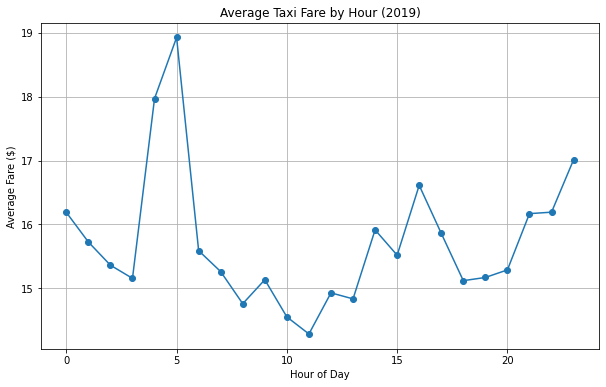

pickup_hour,avg_fare
0,16.189309683604822
1,15.726210884353534
2,15.3633812260535
3,15.157526315789418
4,17.969626485568742
5,18.92472703062573
6,15.590855986118928
7,15.262665589660871
8,14.76081880612816
9,15.135892661555653


In [0]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
pandas_df = agg_df.toPandas()

# Plot average fare by hour
plt.figure(figsize=(10, 6))
plt.plot(pandas_df["pickup_hour"], pandas_df["avg_fare"], marker="o")
plt.title("Average Taxi Fare by Hour (2019)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare ($)")
plt.grid(True)
plt.show()

# Alternative: Use Databricks display for built-in visualization
display(agg_df) 

In [0]:
# Basic stats (e.g., total trips, avg distance)
stats_df = cleaned_df.agg({"trip_distance": "avg", "total_amount": "avg", "VendorID": "count"}) \
                     .withColumnRenamed("avg(trip_distance)", "avg_distance") \
                     .withColumnRenamed("avg(total_amount)", "avg_fare") \
                     .withColumnRenamed("count(VendorID)", "total_trips")

stats_df.show()

+------------------+-----------+------------------+
|          avg_fare|total_trips|      avg_distance|
+------------------+-----------+------------------+
|15.515149439693023|      76653|2.8322617510077692|
+------------------+-----------+------------------+

